In [1]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional

import matplotlib.pyplot as plt
from torchvision.io import read_image

In [5]:
# Install the Penn-Fudan Database for Pedestrian Detection and Segmentation

!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip -P data
!cd data && yes | unzip PennFudanPed.zip

--2024-04-27 15:17:37--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘data/PennFudanPed.zip.6’

PennFudanPed.zip.6  100%[===================>]  51.23M  3.49MB/s    in 17s     

2024-04-27 15:17:54 (3.09 MB/s) - ‘data/PennFudanPed.zip.6’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
replace PennFudanPed/added-object-list.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: PennFudanPed/added-object-list.txt  
replace PennFudanPed/Annotation/FudanPed00001.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: PennFudanPed/Annotation/FudanPed00001.txt  
replace PennFudanPed/Annotation/FudanPed00002.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename:   inflating: PennFudanPed/Annotation/FudanPed00002.tx

In [2]:
print(torch.__version__)

2.2.0+cpu


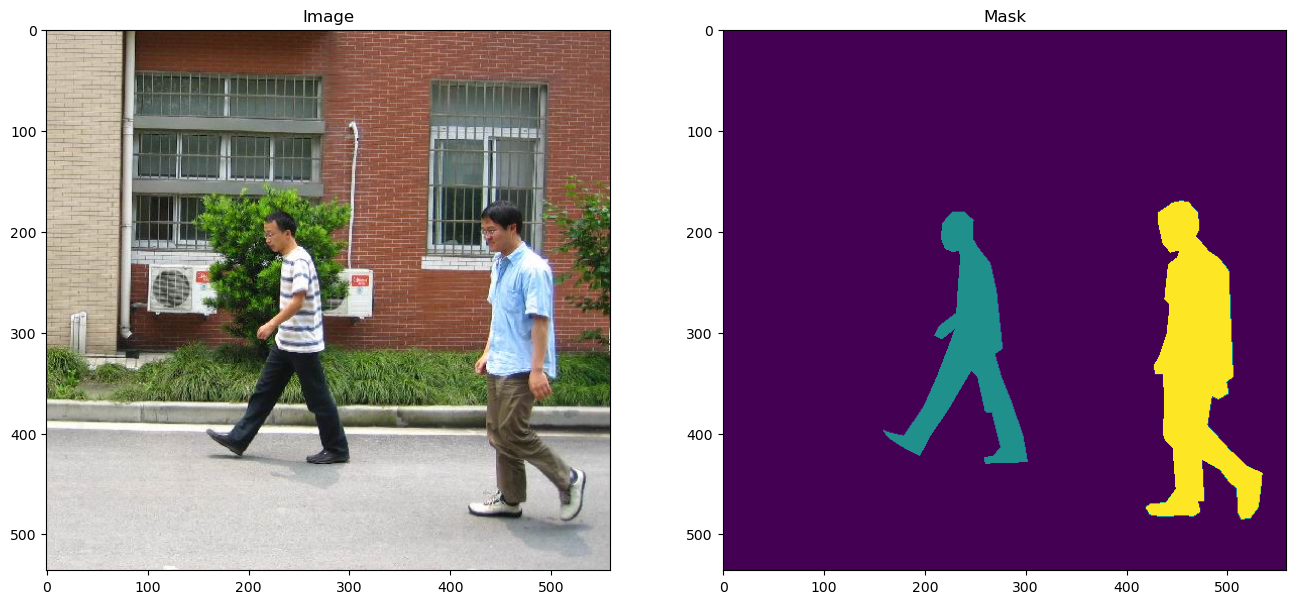

In [3]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00001.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00001_mask.png")

# Display an example mask and image
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")

plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [4]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


# Loading in the dataset
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms

        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        img = read_image(img_path)
        mask = read_image(mask_path)

        obj_ids = torch.unique(mask)

        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        boxes = masks_to_boxes(masks)

        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

num_classes = 2

in_features = model.roi_heads.box_predictor.cls_score.in_features

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [6]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator


backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features

backbone.out_channels = 1280

anchor_generator = AnchorGenerator(
    sizes=((32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features

    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [8]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-04-27 19:37:50--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.12’

     0K ...                                                   100% 2.05M=0.002s

2024-04-27 19:37:50 (2.05 MB/s) - ‘engine.py.12’ saved [4063/4063]

--2024-04-27 19:37:50--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/pl

0

In [9]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [10]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiproc

{'loss_classifier': tensor(0.2501, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0710, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0668, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0018, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [11]:
from engine import train_one_epoch, evaluate


device = torch.device('cpu')

num_classes = 2

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 2

import datetime

print(f"Start time: {datetime.datetime.now()}")

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    print(f"time check: {datetime.datetime.now()}")

print(f"End time: {datetime.datetime.now()}")

Start time: 2024-04-27 16:27:36.983459
Epoch: [0]  [ 0/60]  eta: 0:09:09  lr: 0.000090  loss: 3.4001 (3.4001)  loss_classifier: 0.9782 (0.9782)  loss_box_reg: 0.3694 (0.3694)  loss_mask: 2.0191 (2.0191)  loss_objectness: 0.0268 (0.0268)  loss_rpn_box_reg: 0.0065 (0.0065)  time: 9.1558  data: 0.2407
Epoch: [0]  [10/60]  eta: 0:06:27  lr: 0.000936  loss: 1.8001 (1.9867)  loss_classifier: 0.5833 (0.5813)  loss_box_reg: 0.2925 (0.3286)  loss_mask: 0.8309 (1.0544)  loss_objectness: 0.0190 (0.0169)  loss_rpn_box_reg: 0.0049 (0.0056)  time: 7.7469  data: 0.0318
Epoch: [0]  [20/60]  eta: 0:04:57  lr: 0.001783  loss: 0.7426 (1.3150)  loss_classifier: 0.1918 (0.3805)  loss_box_reg: 0.2036 (0.2666)  loss_mask: 0.2411 (0.6486)  loss_objectness: 0.0139 (0.0149)  loss_rpn_box_reg: 0.0033 (0.0045)  time: 7.3457  data: 0.0099
Epoch: [0]  [30/60]  eta: 0:03:39  lr: 0.002629  loss: 0.5271 (1.0674)  loss_classifier: 0.1037 (0.2877)  loss_box_reg: 0.1841 (0.2645)  loss_mask: 0.1781 (0.4961)  loss_objectne

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callbac

Epoch: [0]  [59/60]  eta: 0:00:07  lr: 0.005000  loss: 0.3313 (0.7382)  loss_classifier: 0.0484 (0.1729)  loss_box_reg: 0.1395 (0.2106)  loss_mask: 0.1695 (0.3403)  loss_objectness: 0.0013 (0.0091)  loss_rpn_box_reg: 0.0035 (0.0053)  time: 7.0923  data: 0.0089
Epoch: [0] Total time: 0:07:16 (7.2711 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:02:59  model_time: 3.0187 (3.0187)  evaluator_time: 0.0106 (0.0106)  time: 3.5983  data: 0.5689


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callbac

Test:  [49/50]  eta: 0:00:03  model_time: 2.9715 (3.0019)  evaluator_time: 0.0043 (0.0062)  time: 3.1000  data: 0.0048
Test: Total time: 0:02:31 (3.0287 s / it)
Averaged stats: model_time: 2.9715 (3.0019)  evaluator_time: 0.0043 (0.0062)
Accumulating evaluation results...
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.718
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.870
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.589
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.730
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.769
 Av

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callbac

Epoch: [1]  [59/60]  eta: 0:00:07  lr: 0.005000  loss: 0.2465 (0.2700)  loss_classifier: 0.0396 (0.0383)  loss_box_reg: 0.0597 (0.0802)  loss_mask: 0.1339 (0.1452)  loss_objectness: 0.0007 (0.0017)  loss_rpn_box_reg: 0.0040 (0.0046)  time: 7.5765  data: 0.0089
Epoch: [1] Total time: 0:07:37 (7.6178 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:02:54  model_time: 3.0031 (3.0031)  evaluator_time: 0.0103 (0.0103)  time: 3.4963  data: 0.4828


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in _

Test:  [49/50]  eta: 0:00:03  model_time: 2.8943 (3.0110)  evaluator_time: 0.0041 (0.0049)  time: 3.0813  data: 0.0044
Test: Total time: 0:02:31 (3.0342 s / it)
Averaged stats: model_time: 2.8943 (3.0110)  evaluator_time: 0.0041 (0.0049)
Accumulating evaluation results...
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.756
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.572
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.771
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.304
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.800
 Av

In [11]:
import torch
import intel_extension_for_pytorch as ipex
from engine import train_one_epoch, evaluate
import datetime

device = torch.device('cpu')

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_classes = 2

model = get_model_instance_segmentation(num_classes)

model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.float32)
model = model.to(device)

num_epochs = 2

print(f"Start time: {datetime.datetime.now()}")

for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    print(f"time check: {datetime.datetime.now()}")

print(f"End time: {datetime.datetime.now()}")


[2024-04-27 19:38:55,678] [INFO] [real_accelerator.py:191:get_accelerator] Setting ds_accelerator to cpu (auto detect)
Start time: 2024-04-27 19:39:05.005147


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callbac

Test:  [49/50]  eta: 0:00:04  model_time: 4.3891 (4.2614)  evaluator_time: 0.0579 (0.0599)  time: 4.3548  data: 0.0046
Test: Total time: 0:03:36 (4.3386 s / it)
Averaged stats: model_time: 4.3891 (4.2614)  evaluator_time: 0.0579 (0.0599)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Av

Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callbac

creating index...
index created!
Test:  [ 0/50]  eta: 0:04:29  model_time: 4.7014 (4.7014)  evaluator_time: 0.0787 (0.0787)  time: 5.3999  data: 0.6197


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/glob/development-tools/versions/oneapi/2024.1/oneapi/intelpython/envs/pytorch/lib/python3.9/multiprocessing/util.py", line 224, in __call__
    res = self._callbac

Test:  [49/50]  eta: 0:00:04  model_time: 4.0939 (4.1312)  evaluator_time: 0.0551 (0.0610)  time: 4.1968  data: 0.0047
Test: Total time: 0:03:30 (4.2162 s / it)
Averaged stats: model_time: 4.0939 (4.1312)  evaluator_time: 0.0551 (0.0610)
Accumulating evaluation results...
DONE (t=0.05s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.004
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.001
 Av

In [ ]:
import torch
import intel_extension_for_pytorch as ipex
from engine import train_one_epoch, evaluate
import datetime

device = torch.device('cpu')

device = torch.device('cpu')

dataset = PennFudanDataset('data/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])


data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    collate_fn=utils.collate_fn
)

num_classes = 2
model = get_model_instance_segmentation(num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

model, optimizer = ipex.optimize(model, optimizer=optimizer, dtype=torch.bfloat16)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

model = model.to(device)

num_epochs = 2

print(f"Start time: {datetime.datetime.now()}")

for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        with torch.cpu.amp.autocast(enabled=True, dtype=torch.bfloat16):
            outputs = model(images, targets)
            loss = sum(loss for loss in outputs.values())

        loss.backward()
        optimizer.step()

    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)
    print(f"time check: {datetime.datetime.now()}")

print(f"End time: {datetime.datetime.now()}")

Start time: 2024-04-27 19:27:06.130642


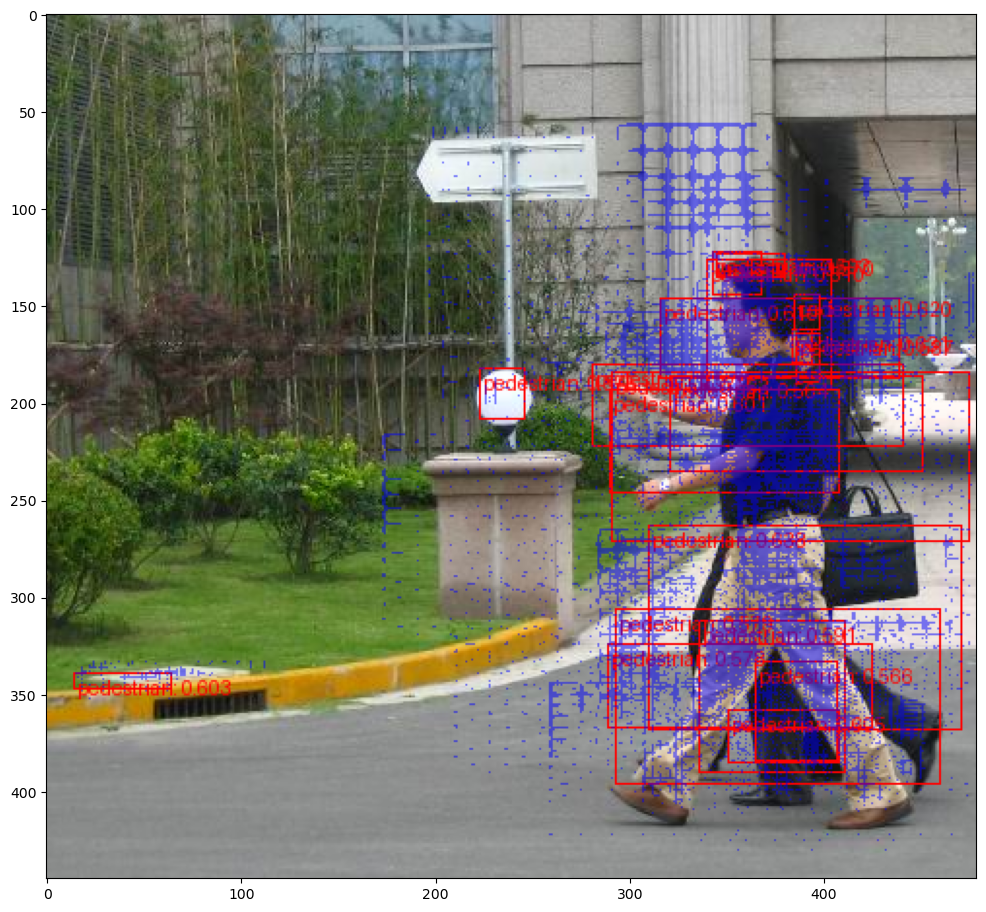

In [29]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks

image = read_image("data/PennFudanPed/PNGImages/FudanPed00003.png")
eval_transform = get_transform(train=False)

with torch.no_grad():
    x = eval_transform(image)
    x = x[:3, ...].to(device)
    predictions = model([x])
    pred = predictions[0]

image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

confidence_threshold = 0.56
person_label = 1
filtered_boxes = []
filtered_labels = []
for label, score, box in zip(pred['labels'], pred['scores'], pred['boxes']):
    if score > confidence_threshold and label == person_label:
        filtered_boxes.append(box)
        filtered_labels.append(f"pedestrian: {score:.3f}")

if filtered_boxes:
    filtered_boxes = torch.stack(filtered_boxes).long()
    output_image = draw_bounding_boxes(image, filtered_boxes, filtered_labels, colors="red")

    if 'masks' in pred:
        masks = (pred['masks'] > 0.9).squeeze(1)
        output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")
else:
    output_image = image

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))
plt.show()